In [25]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

In [26]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1),
        )

    def forward(self, x):
       out = self.net(x)
       return out

def init_weights_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)


In [27]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN().to(device)
        self.model.apply(init_weights_xavier)  # ← Xavier初期化を適用！

        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1+self.h, self.h)
        t = torch.arange(0, 1+self.k, self.k)

        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2, -1).T

        # train data
        # BC and IC define
        bc1 = torch.stack(torch.meshgrid(torch.tensor([x[0]]), t, indexing='ij')).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(torch.tensor([x[-1]]), t, indexing='ij')).reshape(2, -1).T
        ic  = torch.stack(torch.meshgrid(x, torch.tensor([t[0]]), indexing='ij')).reshape(2, -1).T
        #bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2, -1).T # first element value is zero
        #bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2, -1).T # final element value is zero
        #ic = torch.stack(torch.meshgrid(x,t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])

        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(torch.pi * ic[:, 0])

        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)

        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        # optimizer setting
        self.adam = torch.optim.Adam(self.model.parameters())

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno(L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval = 50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )
        self.criterion = torch.nn.MSELoss()
        self.iter = 1

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph=True,
            retain_graph=True
           )[0]

        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]

        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph=True,
            retain_graph=True
        )[0]

        du_dxx = du_dXX[:,0]

        # The key point is to take the MSE between the left and right sides of the PDE.
        # du/dt + u*du/dx = viscocity * d2u/dx2
        loss_pde = self.criterion( du_dt + u.squeeze()*du_dx, (0.01/torch.pi) * du_dxx )
        loss = loss_data + loss_pde
        loss.backward()
        if self.iter % 100 == 0:
            print(self.iter, loss.item())

        self.iter += 1
        return loss

    def train(self):
      self.model.train()
      for i in range(1000):
          self.adam.step(self.loss_func)
      self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [28]:
# training
net = Net()
net.train()


100 0.10542289912700653
200 0.09262090176343918
300 0.08111471682786942
400 0.06684786826372147
500 0.05464944243431091
600 0.03660046309232712
700 0.026115939021110535
800 0.016950029879808426
900 0.014885475859045982
1000 0.010936085134744644
1100 0.0042830235324800014
1200 0.0024134470149874687
1300 0.0013658073730766773
1400 0.000992841087281704
1500 0.0006850353092886508
1600 0.00048409035662189126
1700 0.00039165274938568473
1800 0.0003174356243107468
1900 0.00024931743973866105
2000 0.00021465486497618258
2100 0.00017277049482800066
2200 0.00014216528506949544
2300 0.00012860809511039406
2400 0.00012043067545164376
2500 0.0001035795285133645
2600 9.206994582200423e-05
2700 8.738512406125665e-05
2800 7.944076787680387e-05
2900 7.225236913654953e-05
3000 6.60132645862177e-05
3100 6.28964407951571e-05
3200 6.005023169564083e-05
3300 5.395898915594444e-05
3400 4.8842142859939486e-05
3500 4.5924978621769696e-05
3600 4.3891504901694134e-05


In [29]:
net.model.eval()


NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [30]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x,t)).reshape(2, -1).T
X = X.to(net.X.device)

In [31]:
X.shape

torch.Size([20000, 2])

In [32]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [33]:
y_pred

array([[ 0.00238278,  0.00204196,  0.00178006, ..., -0.00077579,
        -0.00081   , -0.00084613],
       [ 0.03229382,  0.03107347,  0.02997925, ...,  0.00676718,
         0.00667789,  0.00658729],
       [ 0.06238272,  0.06027415,  0.05833866, ...,  0.01432636,
         0.01418152,  0.01403644],
       ...,
       [-0.09462611, -0.09185842, -0.08926151, ..., -0.0248479 ,
        -0.02465615, -0.02446613],
       [-0.06238238, -0.06061307, -0.05896125, ..., -0.01717428,
        -0.01704142, -0.01690987],
       [-0.02986941, -0.02912495, -0.02844272, ..., -0.00951544,
        -0.00944147, -0.00936697]], dtype=float32)

In [34]:
sns.set_style('whitegrid')
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred,cmap='jet')
plt.show()

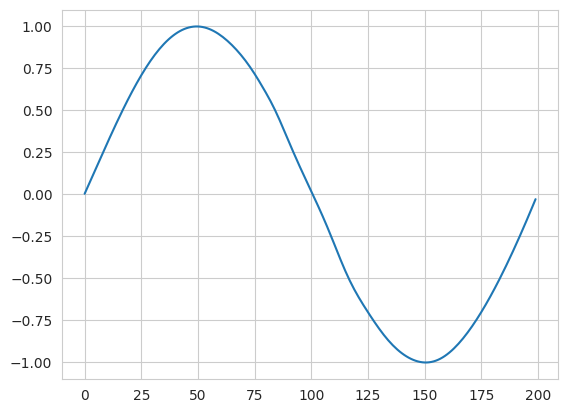

In [35]:
plt.plot(y_pred[:,0])

In [36]:
'''
# for check
x_test = torch.arange(-1,1+0.1, 0.1)
print(x_test)
t_test = torch.arange(0,1+0.1, 0.1)
print(t_test)

X = torch.stack(torch.meshgrid(x_test, t_test)).reshape(2, -1).T
print(X)

#print(torch.meshgrid(x_test,t_test))
'''

'\n# for check\nx_test = torch.arange(-1,1+0.1, 0.1)\nprint(x_test)\nt_test = torch.arange(0,1+0.1, 0.1)\nprint(t_test)\n\nX = torch.stack(torch.meshgrid(x_test, t_test)).reshape(2, -1).T\nprint(X)\n\n#print(torch.meshgrid(x_test,t_test))\n'